### Excercise 1: Fidelity Comparison: Trotter vs Exact Evolution

To evaluate the accuracy of the Trotter approximation, we compute the **quantum fidelity** at each time step:

\\[
F(t) = |\langle \psi_{\text{exact}}(t) | \psi_{\text{trotter}}(t) \rangle|^2
\\]

Here:
- \\( \psi_{\text{trotter}}(t) \\): state evolved via Trotter decomposition
- \\( \psi_{\text{exact}}(t) \\): state evolved using the full Hamiltonian

Fidelity measures how close the two wavefunctions are:
- \\( F = 1 \\): perfect match
- \\( F < 1 \\): Trotter error present

This comparison highlights the impact of non-commuting terms and the importance of higher-order Trotter expansions.


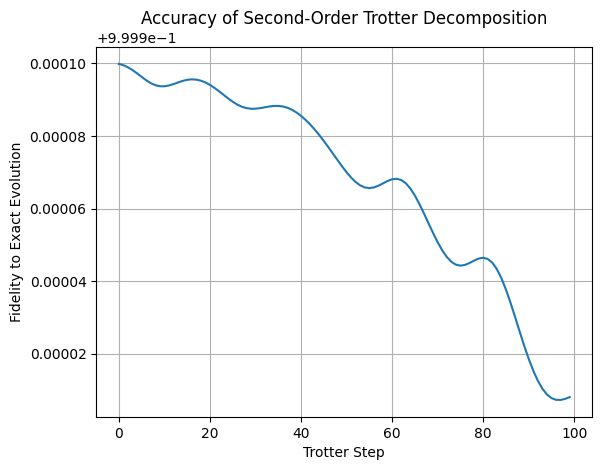

In [10]:
# ▶️ Purpose:
# This code compares the accuracy of second-order Trotter decomposition (Strang splitting)
# with exact time evolution in the 1D transverse-field Ising model. 
# The fidelity is computed between the two quantum states at each time step.

# --- Import necessary libraries ---
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# --- Define Pauli matrices ---
I = np.array([[1, 0], [0, 1]], dtype=complex)   # Identity
X = np.array([[0, 1], [1, 0]], dtype=complex)   # Pauli-X
Z = np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli-Z

# --- Simulation parameters ---
L = 4              # Number of qubits
J = 1.0            # Coupling strength
h = 1.0            # Transverse field strength
delta_t = 0.05     # Time step
steps = 100        # Total Trotter steps

# --- Helper function: Kronecker product of operator list ---
def kron_n(op_list):
    result = op_list[0]
    for op in op_list[1:]:
        result = np.kron(result, op)
    return result

# --- Build interaction Hamiltonian: H_z = -J Σ Z_i Z_{i+1} ---
def build_Hz(L):
    H = np.zeros((2**L, 2**L), dtype=complex)
    for i in range(L):
        ops = [I]*L
        ops[i] = Z
        ops[(i+1)%L] = Z  # Periodic boundary
        H -= J * kron_n(ops)
    return H

# --- Build transverse field Hamiltonian: H_x = -h Σ X_i ---
def build_Hx(L):
    H = np.zeros((2**L, 2**L), dtype=complex)
    for i in range(L):
        ops = [I]*L
        ops[i] = X
        H -= h * kron_n(ops)
    return H

# --- Build the Hamiltonians ---
Hz = build_Hz(L)
Hx = build_Hx(L)

# --- Trotter unitary operators (second-order splitting) ---
U_x_half = la.expm(-1j * Hx * delta_t / 2)
U_z_full = la.expm(-1j * Hz * delta_t)

# --- Initial state: |000...0⟩ ---
psi0 = np.zeros(2**L, dtype=complex)
psi0[0] = 1.0

# --- Build exact evolution operator for comparison ---
H_full = Hz + Hx
U_exact = la.expm(-1j * H_full * delta_t)

# --- Initialize state copies for evolution ---
psi_exact = psi0.copy()
psi_trotter = psi0.copy()
fidelities = []

# --- Run evolution and compute fidelity at each step ---
for _ in range(steps):
    # Second-order Trotter evolution
    psi_trotter = U_x_half @ psi_trotter
    psi_trotter = U_z_full @ psi_trotter
    psi_trotter = U_x_half @ psi_trotter

    # Exact evolution
    psi_exact = U_exact @ psi_exact

    # Compute fidelity: |⟨ψ_exact | ψ_trotter⟩|²
    F = np.abs(np.vdot(psi_exact, psi_trotter))**2
    fidelities.append(F)

# --- Plot fidelity over time ---
plt.plot(fidelities, label='Fidelity')
plt.xlabel('Trotter Step')
plt.ylabel('Fidelity to Exact Evolution')
plt.title('Accuracy of Second-Order Trotter Decomposition')
plt.grid(True)
plt.show()


### Exercise 2: Interpretation: Fidelity of Second-Order Trotter Decomposition

The plot above shows the **fidelity** between the Trotter-evolved quantum state and the exact-evolved state as a function of Trotter steps.

Fidelity is defined as:

\\[
F(t) = |\langle \psi_{\text{exact}}(t) | \psi_{\text{trotter}}(t) \rangle|^2
\\]

Key observations:

- The fidelity starts **very close to 1**, indicating the initial state is identical in both evolutions.
- Over time, the fidelity **gradually decreases**, which reflects the **accumulation of Trotter error** due to the non-commutativity of \( H_Z \) and \( H_X \).
- The second-order Trotter method performs well initially, but as the number of steps increases, small errors build up, causing the two states to diverge slightly.
- The oscillatory pattern in fidelity reflects interference effects due to the system’s quantum dynamics under Trotterized evolution.

This behavior is expected: while the second-order Trotter decomposition provides better accuracy than first-order, it still approximates the full evolution operator and therefore introduces **controlled unitary errors**.

The result confirms that the method is suitable for **short- to intermediate-time dynamics**, but care must be taken for long simulations or when high precision is required.


### Time Evolution of Entanglement Entropy

To probe quantum correlations in our system, we compute the **entanglement entropy** between the left and right halves of the spin chain during time evolution.

For a pure state \( |\psi(t)\rangle \), the entanglement entropy of a subsystem \( A \) is defined as:

\\[
S_A(t) = -\mathrm{Tr}[\rho_A(t) \log \rho_A(t)]
\\]

where \\( \rho_A(t) = \mathrm{Tr}_B[|\psi(t)\rangle\langle\psi(t)|] \\) is the reduced density matrix of subsystem \( A \), obtained by tracing out the degrees of freedom in \( B \).

This quantity captures the amount of quantum entanglement between subsystems. For a 1D transverse-field Ising model, entanglement typically grows with time, reflecting the spread of quantum correlations across the system.


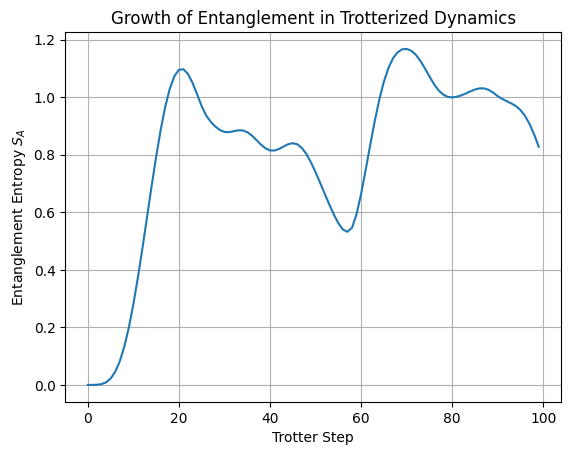

In [11]:
# ▶️ Purpose:
# This code computes and tracks the entanglement entropy of the evolving quantum state
# under second-order Trotterized dynamics of the transverse-field Ising model.

# --- Function to compute bipartite entanglement entropy ---
def entanglement_entropy(psi, L, A_size):
    """Compute von Neumann entanglement entropy S_A for subsystem A of size A_size."""
    psi_tensor = psi.reshape([2]*L)  # Reshape into tensor form
    psi_tensor = psi_tensor.reshape((2**A_size, 2**(L - A_size)))  # Partition into A|B
    rho_A = psi_tensor @ psi_tensor.conj().T  # Reduced density matrix ρ_A
    eigvals = np.linalg.eigvalsh(rho_A)  # Eigenvalues of ρ_A
    eigvals = eigvals[eigvals > 1e-12]   # Remove numerical noise
    entropy = -np.sum(eigvals * np.log2(eigvals))  # von Neumann entropy
    return entropy

# --- Initialize state ---
psi = psi0.copy()
entropies = []

# --- Time evolution loop and entropy calculation ---
for _ in range(steps):
    # Trotter evolution
    psi = U_x_half @ psi
    psi = U_z_full @ psi
    psi = U_x_half @ psi

    # Entanglement across middle cut
    S = entanglement_entropy(psi, L=L, A_size=L//2)
    entropies.append(S)

# --- Plot entanglement entropy ---
plt.plot(entropies)
plt.xlabel("Trotter Step")
plt.ylabel("Entanglement Entropy $S_A$")
plt.title("Growth of Entanglement in Trotterized Dynamics")
plt.grid(True)
plt.show()


### Conclusion: Entanglement Entropy in Trotterized Evolution

The plot above illustrates the **growth of entanglement entropy** in a 1D transverse-field Ising model undergoing second-order Trotterized time evolution.

Initially, the system starts in a product state with zero entanglement. As time evolves, **quantum correlations** build up between the two halves of the system, leading to a **rapid increase in the von Neumann entropy**.

We observe:

- A steep rise in entropy at early times, signaling the spread of quantum entanglement.
- Subsequent oscillations, which reflect the **coherent nature of unitary evolution** under the Trotterized Hamiltonian.
- No saturation to maximal entropy, consistent with finite-size effects and the integrability of the model.

This behavior confirms that the Trotterized dynamics successfully captures the **non-trivial entanglement structure** of the underlying quantum system, while also providing a diagnostic for the **entanglement growth rate** and simulation fidelity.

